In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
from wordcloud import WordCloud

# Models
nltk.download('vader_lexicon')

from pathlib import Path
import warnings
from tqdm.notebook import tqdm
import pprint
from datetime import datetime
from time import time
import os

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/paulschmitt/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Setup

In [21]:
# Set random seed
np.random.seed(1040)

In [82]:
DIR = Path("data")
input_dir = DIR / "input"
stream_1_path = input_dir / "Stream1.xlsx"
stream_2_path = input_dir / "Stream2.xlsx"
stream_3_path = input_dir / "Stream3.xlsx"

In [23]:
# this is ok and will not cause problems
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

stream_1_data = pd.read_excel(stream_2_path, engine="openpyxl") # stream 1 contains the chronologically second part
stream_2_data = pd.read_excel(stream_1_path, engine="openpyxl") # stream 2 contains the chronologically first part
stream_3_data = pd.read_excel(stream_3_path, engine="openpyxl")

stream_data = pd.concat([stream_1_data, stream_2_data, stream_3_data], ignore_index=True);

# First Glimpse

The data contains a great number of different attributes for each observation.
therefore we start by looking at the attributes to get an idea of what to keep and what to get rid of.

First we convert all attribute-names to lowercase and replace white-spaces to underscores to make things simpler

In [24]:
stream_data.columns = [c.replace(' ', '_').lower() for c in stream_1_data.columns]
stream_1_data.columns = [c.replace(' ', '_').lower() for c in stream_1_data.columns]
stream_2_data.columns = [c.replace(' ', '_').lower() for c in stream_1_data.columns]
stream_3_data.columns = [c.replace(' ', '_').lower() for c in stream_1_data.columns]

In [25]:
stream_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150024 entries, 0 to 150023
Data columns (total 63 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   post_id                                      143071 non-null  object 
 1   sound_bite_text                              150015 non-null  object 
 2   ratings_and_scores                           0 non-null       float64
 3   title                                        71124 non-null   object 
 4   source_type                                  143053 non-null  object 
 5   post_type                                    85476 non-null   object 
 6   is_paid                                      150000 non-null  object 
 7   media_type                                   143053 non-null  object 
 8   url                                          143053 non-null  object 
 9   media_link                                   17428 non-null

Important:

- post_id (ID)
- Sound Bite Text (main text corpus)
- Published Date (GMT+01:00) London (used to create dynamic embeddings)
- Sentiment (used for extrinsic evaluation)

In the following I focus first on these attributes to keep things clear and simple

In [26]:
important_attributes = ["post_id", "sound_bite_text", "published_date_(gmt+01:00)_london", "sentiment"]

stream_data_filtered = pd.DataFrame(stream_data, columns=important_attributes)
stream_1_data_filtered = pd.DataFrame(stream_1_data, columns=important_attributes)
stream_2_data_filtered = pd.DataFrame(stream_2_data, columns=important_attributes)
stream_3_data_filtered = pd.DataFrame(stream_3_data, columns=important_attributes)

For simplicity's sake I chose to rename the attributes to a more readable and manageable form

In [27]:
stream_data_filtered.rename(columns={"source_type": "source", "sound_bite_text":"text", "published_date_(gmt+01:00)_london": "date", "post_id":"id"}, inplace=True)

stream_1_data_filtered.rename(columns={"source_type": "source", "sound_bite_text":"text", "published_date_(gmt+01:00)_london": "date", "post_id":"id"}, inplace=True)
stream_2_data_filtered.rename(columns={"source_type": "source", "sound_bite_text":"text", "published_date_(gmt+01:00)_london": "date", "post_id":"id"}, inplace=True)
stream_3_data_filtered.rename(columns={"source_type": "source", "sound_bite_text":"text", "published_date_(gmt+01:00)_london": "date", "post_id":"id"}, inplace=True)

Lets look at how many values are actually there for the selected attributes

In [28]:
# number of observations
n = len(stream_data_filtered)

# Display relative counts of missing values
stream_data_filtered.isnull().sum().divide(n).sort_values(ascending=False)

sentiment    0.046466
id           0.046346
date         0.000160
text         0.000060
dtype: float64

Both the date and the text have almost no missing values, which is the main thing.
The attribute sentiment will only be used for a part of the evaluation of the embeddings and is therefore not as important.
I therefore decide to go for the following strategy:

Remove observations:

- with missing date
- with missing text

Keep observations:
- with missing sentiment

In [29]:
stream_data_filtered.dtypes

id           object
text         object
date         object
sentiment    object
dtype: object

Let us now describe the key characteristics of our (remaining) data

In [30]:
stream_data_filtered.head()

id  \
0   101043269988443_685479222937141_641761047285352   
1  102479025168087_499693558822805_1195202924611670   
2     10643211755_10161745802786756_627308188838071   
3    10643211755_10161748775911756_1235289853921186   
4  101043269988443_687503842734679_3330045383891840   

                                                text                     date  \
0  Check this guy out at a school board meeting. ...  Sep 16, 2022 6:29:09 AM   
1  Trump's one race theory like that of Hitler is...  Jul 31, 2022 1:10:33 AM   
2  Jon C Treleaven Seems right! I believe in pare...  Sep 26, 2022 5:17:42 PM   
3  This happening in my town. We’re having school...  Sep 27, 2022 4:23:12 AM   
4  The blame for all these perverted lifestyles b...   Sep 5, 2022 6:10:30 PM   

   sentiment  
0   Neutrals  
1   Neutrals  
2   Neutrals  
3  Positives  
4   Neutrals

In [31]:
stream_data_filtered.shape

(150024, 4)

In [32]:
stream_data_filtered.dtypes

id           object
text         object
date         object
sentiment    object
dtype: object

The datatypes are mostly as we would like.
We only convert the date attribute from object to date, since we are working with a time series.

In [33]:
stream_data_filtered['date'].isnull().sum()

24

Given that temporal word embeddings heavily rely on dates, we consider the date to be crucial. However, out of the 24 tweets available, some lack a date, so I opt to eliminate those observations from the dataset.

In [34]:
stream_data_filtered.dropna(subset=['date'], inplace=True)

stream_1_data_filtered.dropna(subset=['date'], inplace=True)
stream_2_data_filtered.dropna(subset=['date'], inplace=True)
stream_3_data_filtered.dropna(subset=['date'], inplace=True)

In [35]:
stream_data_filtered['date'] =  pd.to_datetime(stream_data_filtered['date'])

stream_1_data_filtered['date'] =  pd.to_datetime(stream_1_data_filtered['date'])
stream_2_data_filtered['date'] =  pd.to_datetime(stream_2_data_filtered['date'])
stream_3_data_filtered['date'] =  pd.to_datetime(stream_3_data_filtered['date'])

Since I focus on the temporal change of words, I chose to sort the observations by date because that makes a manual inspection later on more convenient

In [36]:
stream_data_filtered.sort_values('date');

The text of the tweets is the main source of information, lets look how many missing values we encounter here

In [37]:
null_texts = stream_data_filtered['text'].isnull().sum()
empty_texts = stream_data_filtered[stream_data_filtered['text'].str.len() < 2].count().iloc[0]
print(f"Obsersations with no text: {null_texts}")
print(f"Obsersations with empty text: {empty_texts}")

Obsersations with no text: 0
Obsersations with empty text: 0


Since it is only one observation we can safely remove it to prevent it from causing errors later on.

In [38]:
stream_data_filtered.dropna(subset=['text'], inplace=True)

Now lets take a look at the different attributes.
Since the task at hand is a sentiment analysis, we focus on this attribute first

In [39]:
stream_data_filtered["sentiment"].unique()

array(['Neutrals', 'Positives', 'Negatives', nan, 'Mixed'], dtype=object)

So our target is to predict the sentiment from the text (sound_bite_text).
The sentiment is either:

- Positive
- Negative
- Neutral
- Mixed

We can look how the target labels are distributed.

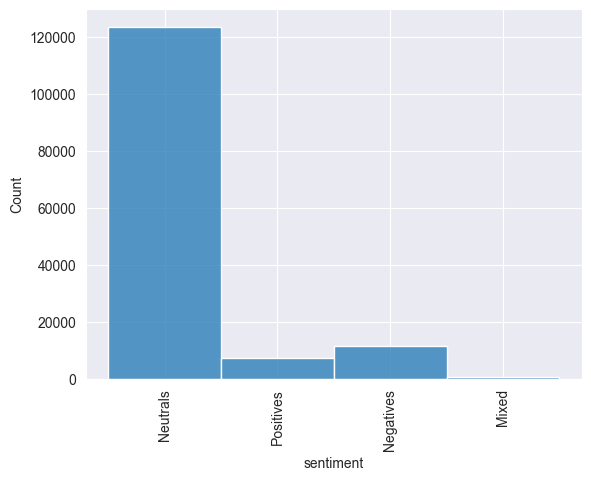

In [40]:
hist = sns.histplot(data=stream_data_filtered, x="sentiment")
hist.tick_params(axis='x', rotation=90)
plt.show()

In [41]:
stream_data_filtered["sentiment"].value_counts()

Neutrals     123429
Negatives     11575
Positives      7431
Mixed           618
Name: sentiment, dtype: int64

Unfortunately the labels are far from being evenly distributed.
Most labels are neutral with only a few being negative and positive.
Luckily we have a relatively big sample size with still many texts having either a negative or
a positive sentiment.

# Data Preprocessing

## Date

In [42]:
# Get the range of dates
date_range = (stream_data_filtered['date'].min(), stream_data_filtered['date'].max())
date_range_stream_1 = (stream_1_data_filtered['date'].min(), stream_1_data_filtered['date'].max())
date_range_stream_2 = (stream_2_data_filtered['date'].min(), stream_2_data_filtered['date'].max())
date_range_stream_3 = (stream_3_data_filtered['date'].min(), stream_3_data_filtered['date'].max())

# Format the output
formatted_range = tuple(date.strftime("%Y-%m-%d") for date in date_range)
formatted_range_stream_1 = tuple(date.strftime("%Y-%m-%d") for date in date_range_stream_1)
formatted_range_stream_2 = tuple(date.strftime("%Y-%m-%d") for date in date_range_stream_2)
formatted_range_stream_3 = tuple(date.strftime("%Y-%m-%d") for date in date_range_stream_3)

print("Date range all:", formatted_range)
print("-----------------------")
print("Date range Stream #1:", formatted_range_stream_1)
print("Date range Stream #2:", formatted_range_stream_2)
print("Date range Stream #3:", formatted_range_stream_3)

Date range all: ('2022-06-01', '2023-04-28')
-----------------------
Date range Stream #1: ('2022-06-01', '2022-09-30')
Date range Stream #2: ('2022-10-01', '2022-12-31')
Date range Stream #3: ('2023-01-01', '2023-04-28')


## Text

### 1. Convert to lowercase

In [43]:
stream_data_filtered["text"] = stream_data_filtered["text"].str.lower()

stream_1_data_filtered["text"] = stream_1_data_filtered["text"].str.lower()
stream_2_data_filtered["text"] = stream_2_data_filtered["text"].str.lower()
stream_3_data_filtered["text"] = stream_3_data_filtered["text"].str.lower()

### 2. Remove Unicode Characters

Eliminate the punctuation, URL, and @

In [44]:
import re

def clean_text(text):
    # Remove URLs
    #text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove punctuation
    #text = re.sub(r'[^\w\s]', '', text)

    # Remove '@' mentions
    #text = re.sub(r'@', '', text)

    # Removes all of them
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)

    return text

In [45]:
stream_data_filtered["text"] = stream_data_filtered["text"].apply(clean_text)

stream_1_data_filtered["text"] = stream_1_data_filtered["text"].apply(clean_text)
stream_2_data_filtered["text"] = stream_2_data_filtered["text"].apply(clean_text)
stream_3_data_filtered["text"] = stream_3_data_filtered["text"].apply(clean_text)

### 3. Remove Stopwords

In [46]:
import nltk
nltk.download('punkt')

def remove_stopwords(text):
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize

    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return " ".join(filtered_text)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulschmitt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
stream_data_filtered["text"] = stream_data_filtered["text"].apply(remove_stopwords)

stream_1_data_filtered["text"] = stream_1_data_filtered["text"].apply(remove_stopwords)
stream_2_data_filtered["text"] = stream_2_data_filtered["text"].apply(remove_stopwords)
stream_3_data_filtered["text"] = stream_3_data_filtered["text"].apply(remove_stopwords)

### 4. Stemming

In [48]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

def perform_stemming(text):
    stemmer = SnowballStemmer(language = "english")
    word_tokens = word_tokenize(text)
    stemmed_text = [stemmer.stem(word) for word in word_tokens]
    return " ".join(stemmed_text)

In [49]:
stream_data_filtered["text"] = stream_data_filtered["text"].apply(perform_stemming)

stream_1_data_filtered["text"] = stream_1_data_filtered["text"].apply(perform_stemming)
stream_2_data_filtered["text"] = stream_2_data_filtered["text"].apply(perform_stemming)
stream_3_data_filtered["text"] = stream_3_data_filtered["text"].apply(perform_stemming)

# Sample-Engine

***Words to check manually:***

***Politics***
* cancel
* lgbt
* sustainable
* privilege
* police
* tiktok
* twitter
* metaverse
* elon/musk
* donald/trump
* intelligence
* ai
* desantis
* biden

***Corona***
* corona
* vaccines
* teachers
* homeoffice


***CBS-News - The Hottest Topic of each Month:***

***2022***
* Roe v. Wade (June)
* Shinzo Abe (July)
* Trump / Mar-a-Lago (August)
* Queen (September)
* Elon Musk / Twitter (October)
* Republicans / Red Wave (November)
* Russia / Brittney Griner / Prisoner (December)

***2023 (TODO)***
* xxx (January)
* xxx (February)
* xxx (March)
* xxx (April)

Timeframe: 2022-06-01 - 2023-04-28
source: https://www.cbsnews.com/news/the-year-in-review-top-news-stories-of-2022-month-by-month/

### Stream 1 (June-September 2022)

In [50]:
sample_stream_1 = stream_1_data_filtered.sample(1)
print("Stream 1")
print(f"Date: {sample_stream_1['date'].iloc[0].date()}")
print(f"Sentiment: {sample_stream_1['sentiment'].iloc[0]}")
print("----------------")
print(sample_stream_1["text"].iloc[0])

Stream 1
Date: 2022-08-18
Sentiment: Neutrals
----------------
miriam2626 dear georg w laura bush nephew isnt time came book ban isnt time came sensibl abort law isnt time ask parti condemn trump isnt time help save texa


### Stream 2 (October-December 2022)

In [51]:
sample_stream_2 = stream_2_data_filtered.sample(1)
print("Stream 2")
print(f"Date: {sample_stream_2['date'].iloc[0].date()}")
print(f"Sentiment: {sample_stream_2['sentiment'].iloc[0]}")
print("----------------")
print(sample_stream_2["text"].iloc[0])

Stream 2
Date: 2022-11-08
Sentiment: Neutrals
----------------
rumor school jefferson counti accommod student dress like anim provid litter box squelch forc statement board deni stori litter box build student allow come school costum read statement furri student identifi school day substanti claim litter box school presenc furri later confirm email administr obtain kcnctv report said least two dozen parent contact administr student costum refer furri


### Stream 3 (January-April 2023)

In [52]:
sample_stream_3 = stream_3_data_filtered.sample(1)
print("Stream 3")
print(f"Date: {sample_stream_3['date'].iloc[0].date()}")
print(f"Sentiment: {sample_stream_3['sentiment'].iloc[0]}")
print("----------------")
print(sample_stream_3["text"].iloc[0])

Stream 3
Date: 2023-02-25
Sentiment: Negatives
----------------
make school board partisan instead top concern school board member make headlin noth springboard wouldb lawmak said univers north carolina move ban divers equiti inclus statement antiwok backlash ideolog board cite one school system idaho said alreadi experienc point like press transgend youngster around well censor collect north idaho colleg claim elect would certain dread compar destini fall upon administr institut system ran institut anyth partial institut board might end much less qualifi lawmak someth possibleidaho institut board partial well rather lead worri kind institut board particip certain make head


# Data exploration

## Create Corpora

Split corpus into groups according to their sentiment (later analysis) and according to the time interval in which they were published (temporal slices).

In [53]:
corpus_all = stream_data_filtered["text"].values.tolist()

# according to the year they were published
corpus_stream_1 = stream_1_data_filtered["text"].values.tolist() # first 1/3 year
corpus_stream_2 = stream_2_data_filtered["text"].values.tolist() # second 1/3 year
corpus_stream_3 = stream_3_data_filtered["text"].values.tolist() # third 1/3 year

''' -- currently not needed --
# according to their sentiment
corpus_positive = stream_data_filtered[stream_data_filtered.sentiment == "Positives"]["text"].values.tolist()
corpus_negative = stream_data_filtered[stream_data_filtered.sentiment == "Negatives"]["text"].values.tolist()
corpus_neutral = stream_data_filtered[stream_data_filtered.sentiment == "Neutrals"]["text"].values.tolist()
corpus_mixed = stream_data_filtered[stream_data_filtered.sentiment == "Mixed"]["text"].values.tolist()''';

In [79]:
corpus_all

'check guy school board meet'

## Tokenize

In [54]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

# Concatenate the whole text for each type of sentiment
tokens = tokenizer.tokenize(" ".join(str(text) for text in corpus_all))

tokens_stream_1 = tokenizer.tokenize(" ".join(str(text) for text in corpus_stream_1))
tokens_stream_2 = tokenizer.tokenize(" ".join(str(text) for text in corpus_stream_2))
tokens_stream_3 = tokenizer.tokenize(" ".join(str(text) for text in corpus_stream_3))

## Create Vocabulary

In [55]:
# unique vocabulary of each class
vocabulary = set(tokens)
vocabulary_stream_1 = set(tokens_stream_1)
vocabulary_stream_2 = set(tokens_stream_2)
vocabulary_stream_3 = set(tokens_stream_3)

In [56]:
pprint.pprint(vocabulary, compact=True, width=100)

{'0', '00', '000', '0000', '00000', '000000', '000000000000', '00000047', '000001', '0000062',
 '00001', '00001883', '00003', '00003333', '0000459322034', '00007ff7dc23179e', '00007ff7dc2a7a53',
 '00007ff7dc419fb3', '00007ff7dc41b89e', '00007ff7dc41c81f', '00007ff7dc422b64', '00007ff7dc45495d',
 '00007ff7dc4b7622', '00007ff7dc4eacb4', '00007ff7ebe55830', '00007ff9cf601030', '00007ff9cf604828',
 '00007ff9cf6066c0', '00007ff9e9f3039c', '00007ff9eb90244d', '00007ff9ec8b3666', '00007ffde6f2d4fc',
 '00007ffde9aad0af', '00007ffde9acfca5', '00007ffde9b1716f',
 '0000830a08793e3f10ecad58b480cf590f3aeca449da', '00008883', '0000the', '0001', '000100',
 '000100000', '000101', '00011225', '000154', '000192', '0002', '0002001', '000232', '0003', '0004',
 '000400', '000400000', '000401', '000458', '00047address',
 '00047website47ieltsandimmigrationcomimmigr', '0005', '000500', '000500000', '000501000', '000502',
 '000502010', '000502020', '000502030', '000502040', '000503', '000503000', '000504', '00

In [57]:
vocabulary_sizes = {"Stream1": len(vocabulary_stream_1), "Stream2": len(vocabulary_stream_2),
                      "Stream3": len(vocabulary_stream_3)}

vs_df = pd.DataFrame([vocabulary_sizes])

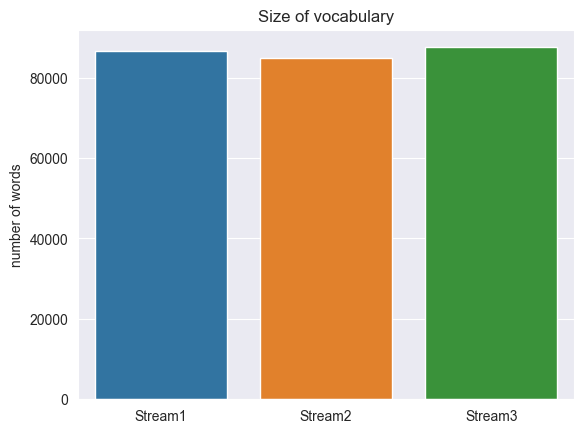

In [58]:
sns.barplot(data=vs_df)
plt.ylabel('number of words')
plt.title('Size of vocabulary')
plt.show()

The analysis reveals that all time slices exhibit a similar vocabulary size, approximately 80.000 words each (post stemming).

In [59]:
# Vocabulary contained in the vocabulary of all time steps

vocabulary_common = vocabulary_stream_1.intersection(vocabulary_stream_2).intersection(vocabulary_stream_3)
len(vocabulary_common)

25252

In [60]:
# Vocabulary unique to one sentiment

vocabulary_stream_1_only = vocabulary_stream_1 - vocabulary_common
vocabulary_stream_2_only = vocabulary_stream_2 - vocabulary_common
vocabulary_stream_3_only = vocabulary_stream_3 - vocabulary_common

In [61]:
vocabulary_split_sizes = {"Stream1": len(vocabulary_stream_1_only), "Stream2": len(vocabulary_stream_2_only),
                    "Stream3": len(vocabulary_stream_3_only)}

vs_split_df = pd.DataFrame([vocabulary_split_sizes])

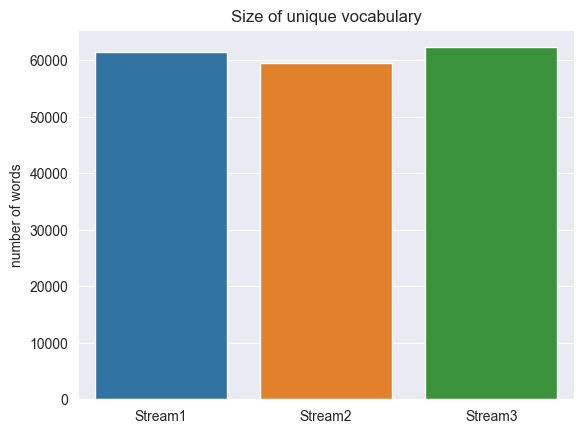

In [62]:
sns.barplot(data=vs_split_df)
plt.ylabel('number of words')
plt.title('Size of unique vocabulary')
plt.show()

We get roughly the same picture as with the non-unique vocabulary

## Frequency distribution of words

### All

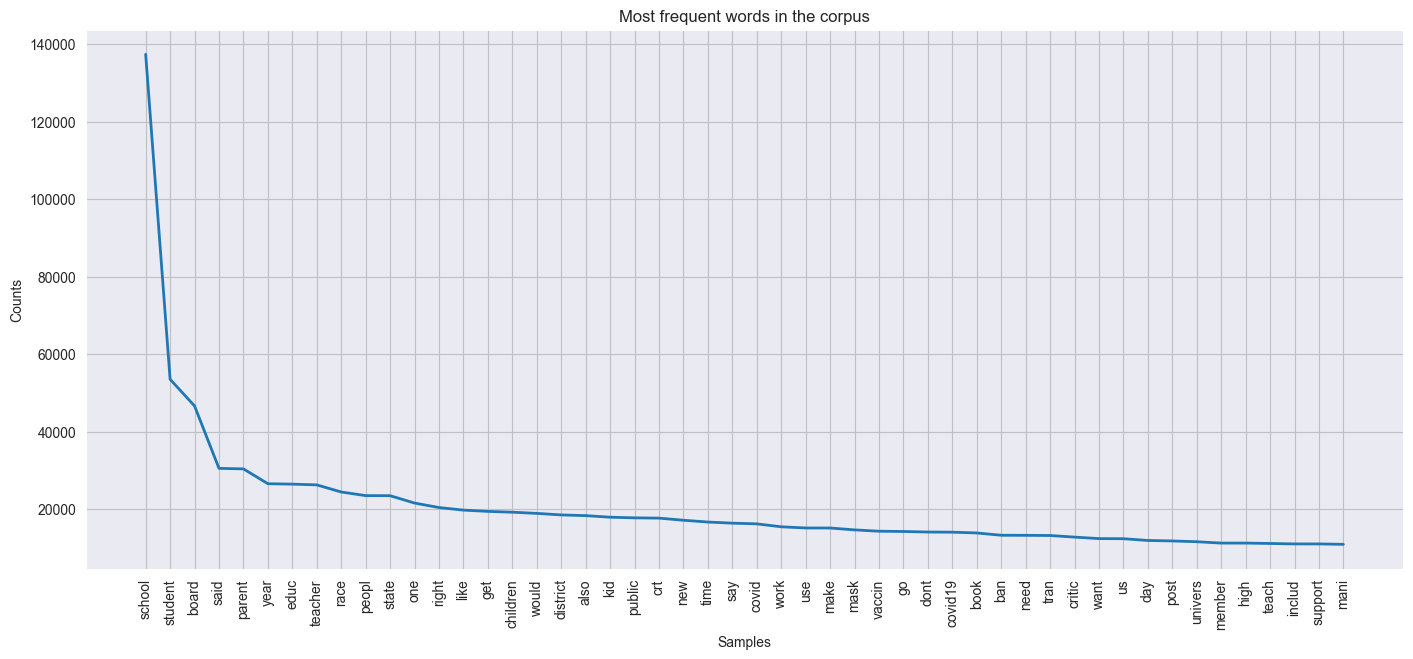

In [63]:
freq_tokens_all = nltk.FreqDist(tokens)

plt.figure(figsize = (17, 7))
freq_tokens_all.plot(50, title = 'Most frequent words in the corpus')
plt.show()

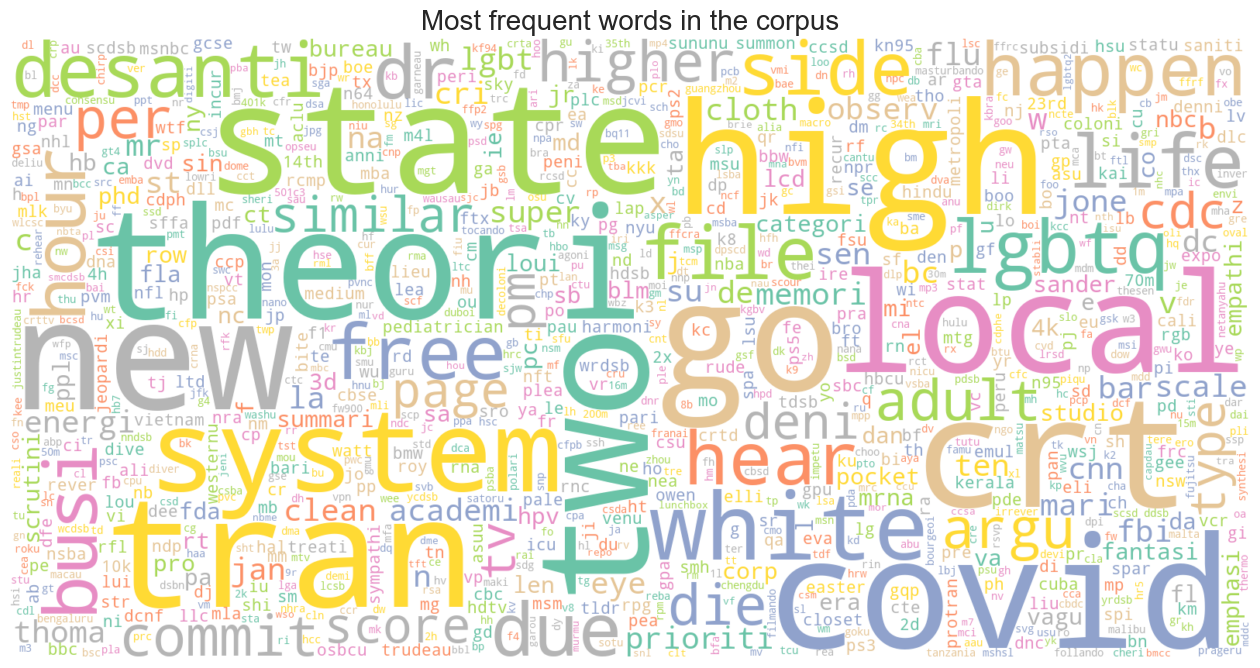

In [64]:
plt.figure(figsize = (16, 13))
wc = WordCloud(background_color = 'white', colormap = 'Set2', max_words = 1000, max_font_size = 200, width = 1600, height = 800)
wc.generate(" ".join(freq_tokens_all))
plt.title('Most frequent words in the corpus', fontsize = 20)
plt.imshow(wc.recolor( colormap = 'Set2' , random_state = 17), alpha = 0.98, interpolation = "bilinear")
plt.axis('off')
plt.show()

### Stream 1

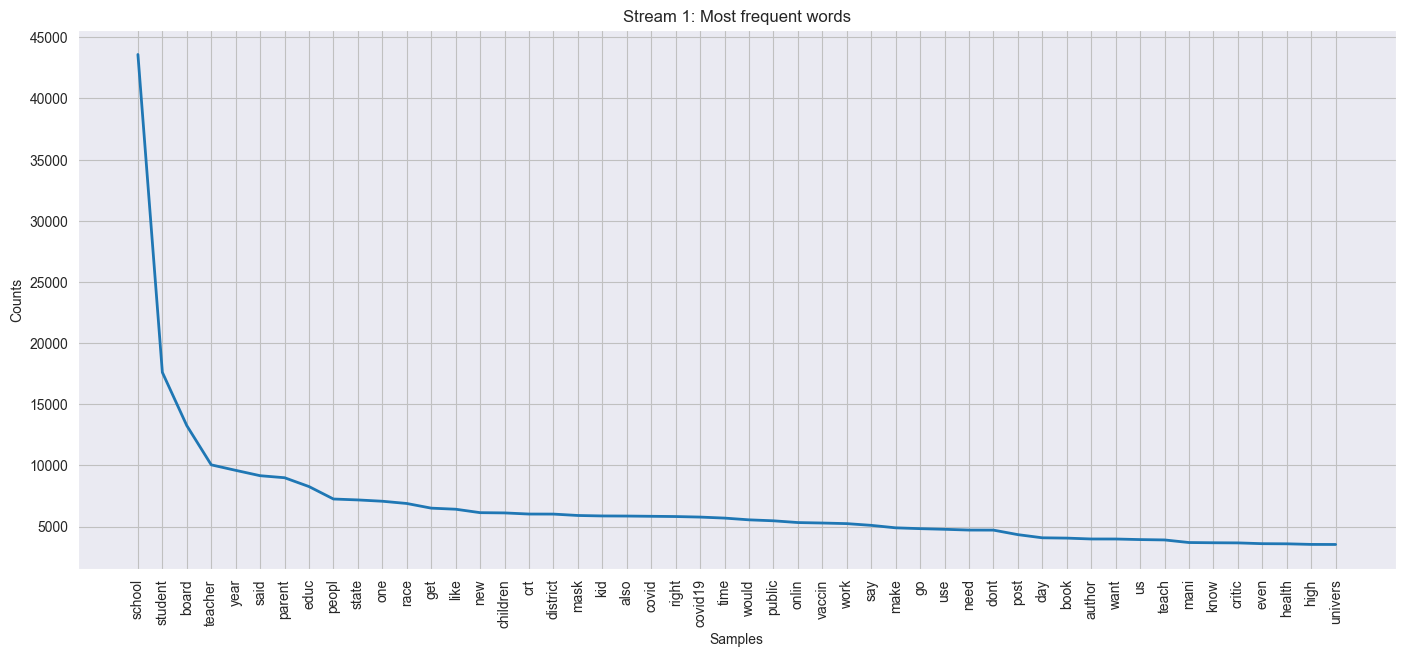

In [65]:
freq_tokens_stream_1 = nltk.FreqDist(tokens_stream_1)

plt.figure(figsize = (17, 7))
freq_tokens_stream_1.plot(50, title = 'Stream 1: Most frequent words')
plt.show()

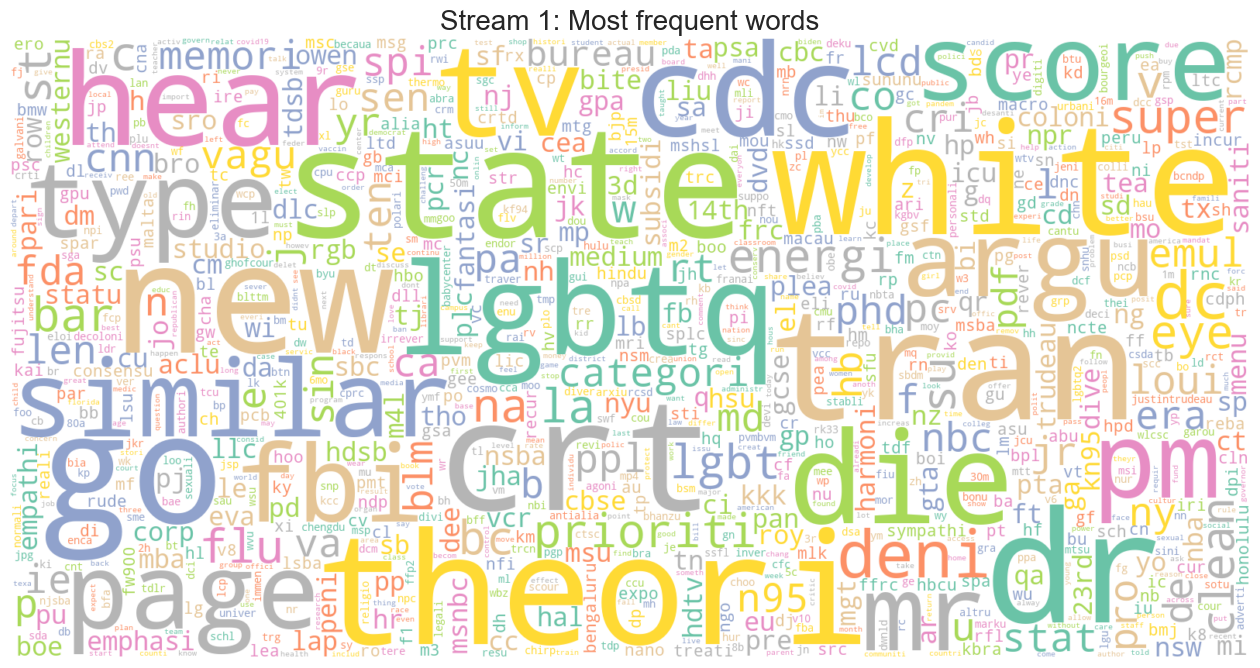

In [66]:
plt.figure(figsize = (16, 13))
wc = WordCloud(background_color = 'white', colormap = 'Set2', max_words = 1000, max_font_size = 200, width = 1600, height = 800)
wc.generate(" ".join(freq_tokens_stream_1))
plt.title('Stream 1: Most frequent words', fontsize = 20)
plt.imshow(wc.recolor( colormap = 'Set2' , random_state = 17), alpha = 0.98, interpolation = "bilinear")
plt.axis('off')
plt.show()

### Stream 2

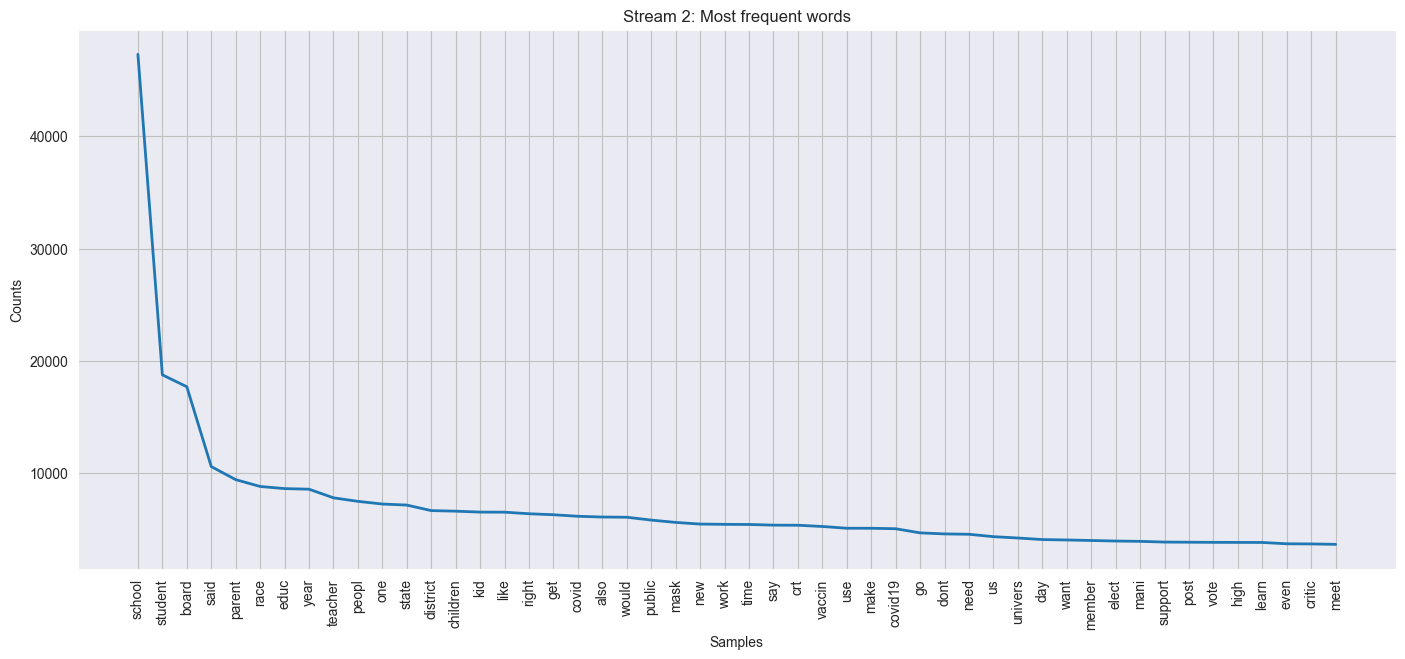

In [67]:
freq_tokens_stream_2 = nltk.FreqDist(tokens_stream_2)

plt.figure(figsize = (17, 7))
freq_tokens_stream_2.plot(50, title = 'Stream 2: Most frequent words')
plt.show()

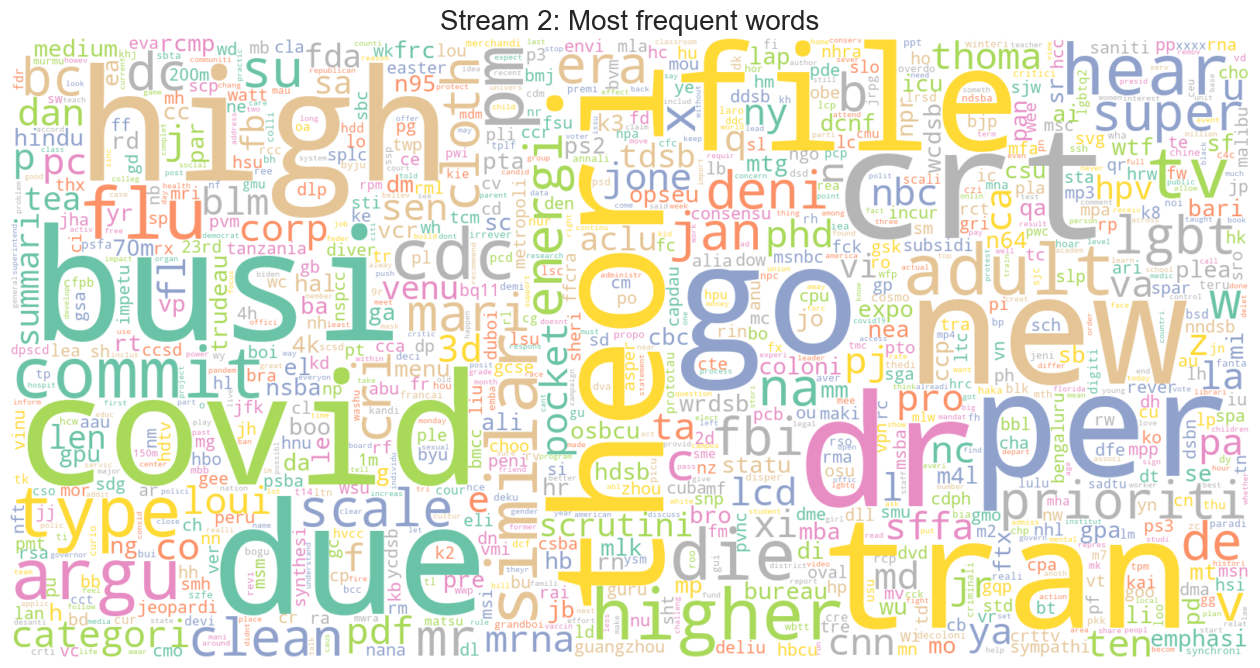

In [68]:
plt.figure(figsize = (16, 13))
wc = WordCloud(background_color = 'white', colormap = 'Set2', max_words = 1000, max_font_size = 200, width = 1600, height = 800)
wc.generate(" ".join(freq_tokens_stream_2))
plt.title('Stream 2: Most frequent words', fontsize = 20)
plt.imshow(wc.recolor( colormap = 'Set2' , random_state = 17), alpha = 0.98, interpolation = "bilinear")
plt.axis('off')
plt.show()

### Stream 3

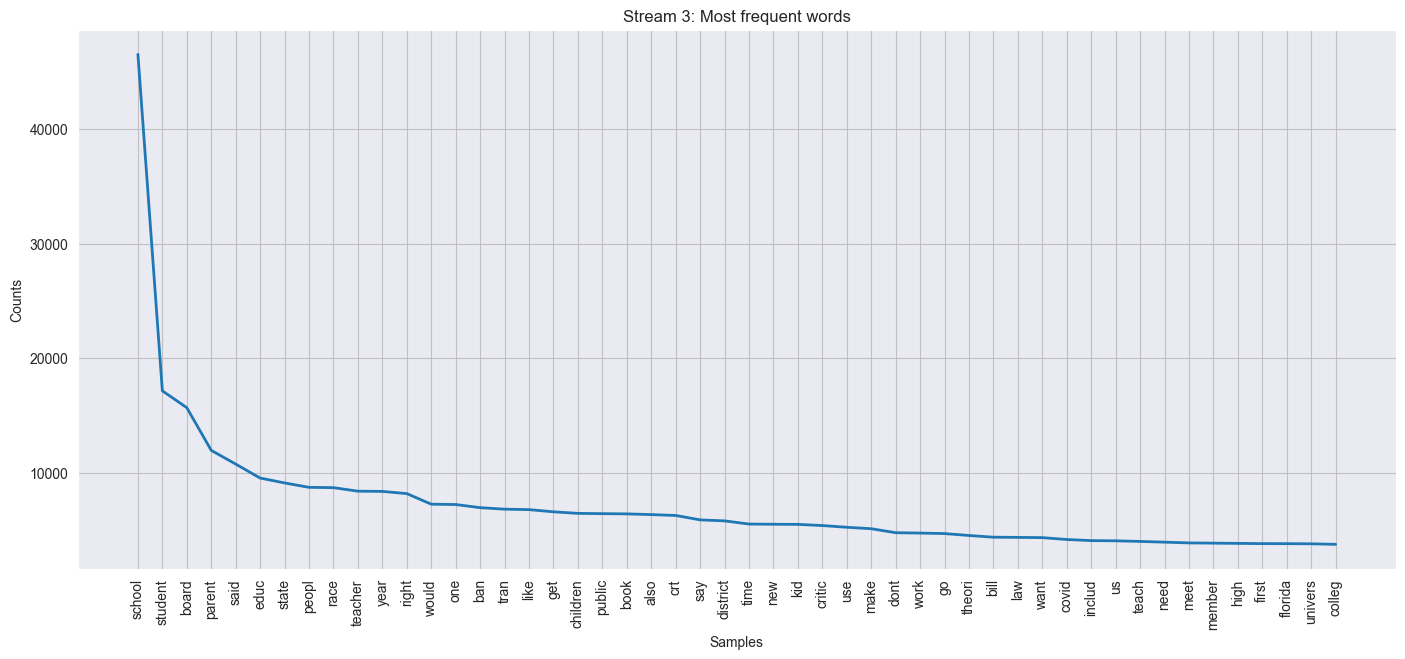

In [69]:
freq_tokens_stream_3 = nltk.FreqDist(tokens_stream_3)

plt.figure(figsize = (17, 7))
freq_tokens_stream_3.plot(50, title = 'Stream 3: Most frequent words')
plt.show()

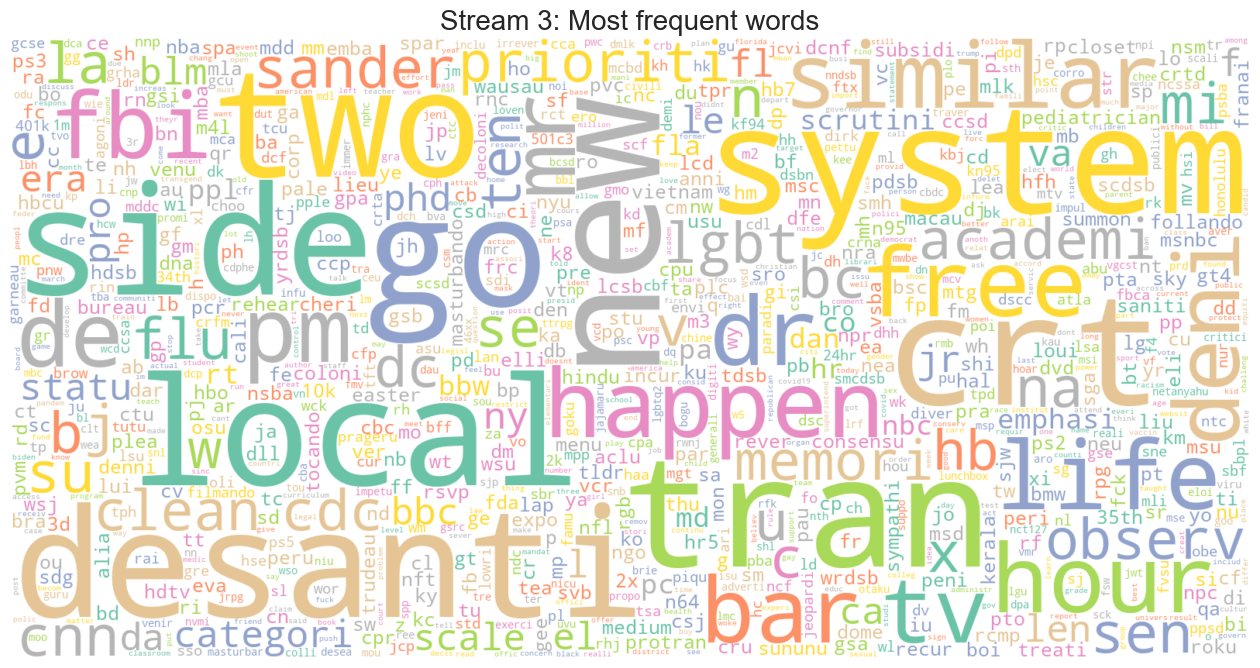

In [70]:
plt.figure(figsize = (16, 13))
wc = WordCloud(background_color = 'white', colormap = 'Set2', max_words = 1000, max_font_size = 200, width = 1600, height = 800)
wc.generate(" ".join(freq_tokens_stream_3))
plt.title('Stream 3: Most frequent words', fontsize = 20)
plt.imshow(wc.recolor( colormap = 'Set2' , random_state = 17), alpha = 0.98, interpolation = "bilinear")
plt.axis('off')
plt.show()

# Word Embeddings

1. Static: Word2Vec (Gensim)
2. Static (State-of-the-art): BERT (TO-DO)
3. Temporal: TWEC/CADE
4. Temporal: Dynamic Word2Vec
5. Custom Word2Vec

## 1. Word2Vec (static)

The parameters:
- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)

- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

- size = int - Dimensionality of the feature vectors. - (50, 300)

- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. (0, 1e-5)

- alpha = float - The initial learning rate - (0.01, 0.05)

- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)

- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [71]:
test_word = "queen"

In [72]:
from gensim.models import Word2Vec

In [81]:
type(corpus_all[0])

str

In [74]:
from nltk import word_tokenize

tokenized_corpus = [word_tokenize(item) for item in tqdm(corpus_all)]

  0%|          | 0/150000 [00:00<?, ?it/s]

In [77]:
tokenized_corpus[0]

['check', 'guy', 'school', 'board', 'meet']

In [81]:
w2v_model = Word2Vec(tokenized_corpus, min_count = 1)

In [86]:
test_word = "queen"
w2v_model.wv.most_similar(test_word)

[('brunch', 0.742483913898468),
 ('mooseknuckl', 0.7224091291427612),
 ('showbrunch', 0.671273946762085),
 ('allag', 0.652148425579071),
 ('resignationto', 0.6503247022628784),
 ('jinkx', 0.6456208229064941),
 ('dragqueen', 0.6134271621704102),
 ('drag', 0.6081909537315369),
 ('axidentaliber', 0.6081470251083374),
 ('oppositeto', 0.6056985259056091)]

## 2. BERT (TO-DO)

## 3. CADE (TWEC)

***Temporal Word Embeddings with a Compass***

* [Source-Code](https://github.com/valedica/twec)

* [Paper](https://arxiv.org/abs/1906.02376)

* [Blogpost](https://fede-bianchi.medium.com/aligning-temporal-diachronic-word-embeddings-with-a-compass-732ab7427955)

Save the concatenated text to txt-files to make them usable for Cade

In [87]:
file_paths_and_corpora = {
     DIR + 'compass.txt': corpus_all,
     DIR + 'stream1.txt': corpus_stream_1,
     DIR + 'stream2.txt': corpus_stream_2,
     DIR + 'stream3.txt': corpus_stream_3
}

# just in case
if not os.path.exists(DIR):
    os.makedirs(DIR)

for file_path, corpus in file_paths_and_corpora.items():
    with open(file_path, 'w') as file:
        for item in corpus:
            file.write("%s\n" % item)

In [88]:
# only needed once for the installation & creation of a venv
''''%%capture
!pip install -U cade
!pip install git+https://github.com/vinid/gensim.git''';

In [89]:
from cade.cade import CADE

Create & train the compass

This creates atemporal context and target word embeddings

In [90]:
aligner = CADE(size=30)
aligner.train_compass(DIR + "compass.txt", overwrite=True);

Training the compass from scratch.


/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


In [91]:
# train slices, they will be already aligned

slice_stream_1 = aligner.train_slice(DIR + "stream1.txt", save=True) # these are gensim word2vec objects
slice_stream_2 = aligner.train_slice(DIR + "stream2.txt", save=True)
slice_stream_3 = aligner.train_slice(DIR + "stream3.txt", save=True)

Training embeddings: slice data/stream1.txt.
Initializing embeddings from compass.


/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(
/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


Training embeddings: slice data/stream2.txt.
Initializing embeddings from compass.


/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(
/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


Training embeddings: slice data/stream3.txt.
Initializing embeddings from compass.


/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


Load the models

In [92]:
from gensim.models.word2vec import Word2Vec
from smart_open import open

model_stream_1 = Word2Vec.load("model/stream1.model")
model_stream_2 = Word2Vec.load("model/stream2.model")
model_stream_3 = Word2Vec.load("model/stream3.model")

/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(
/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(
/Users/paulschmitt/miniforge3/envs/stream1/lib/python3.8/site-packages/smart_open/smart_open_lib.py:408: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warning

In [135]:
test_word = "wave" # amk

August-September 2022

In [136]:
model_stream_1.wv.most_similar(test_word)

[('surg', 0.8737202882766724),
 ('variant', 0.7996873259544373),
 ('exit', 0.7922742962837219),
 ('minim', 0.7855672836303711),
 ('winter', 0.7795059084892273),
 ('milder', 0.7725047469139099),
 ('omicron', 0.7596457004547119),
 ('unfold', 0.7520751953125),
 ('circul', 0.7425119280815125),
 ('subvari', 0.7422152161598206)]

October-December 2022

In [137]:
model_stream_2.wv.most_similar(test_word)

[('exit', 0.7880758047103882),
 ('milder', 0.7853636741638184),
 ('surg', 0.7731313109397888),
 ('subvari', 0.7586109638214111),
 ('omicron', 0.7404664754867554),
 ('winter', 0.7097393274307251),
 ('uptick', 0.7059628367424011),
 ('variant', 0.7027716636657715),
 ('circul', 0.6955614686012268),
 ('amid', 0.6910337805747986)]

January-April 2023

In [138]:
model_stream_3.wv.most_similar(test_word)

[('amid', 0.7919317483901978),
 ('republicanl', 0.7877541184425354),
 ('counterpunch', 0.7535312175750732),
 ('flood', 0.7171070575714111),
 ('rise', 0.6753702163696289),
 ('backlash', 0.6634960770606995),
 ('tension', 0.6628513932228088),
 ('fierc', 0.64794921875),
 ('surg', 0.646097719669342),
 ('nationwid', 0.64588463306427)]

Words that changed their meaning obviously:

* Twitter
* Griner (Brittney)
* wave

Create tokens of the text for the whole corpus as well as for each sentiment separately

In [97]:
from scipy.spatial.distance import cosine

# test_word = "trump"
print(f"Cosine Similarity of word: {test_word}")
print("Timestep 1 to 2")
print(1 - cosine(model_stream_1.wv[test_word], model_stream_2.wv[test_word]))
print("---------------------")
print("Timestep 2 to 3")
print(1 - cosine(model_stream_2.wv[test_word], model_stream_3.wv[test_word]))
print("---------------------")
print("Timestep 1 to 3")
print(1 - cosine(model_stream_1.wv[test_word], model_stream_3.wv[test_word]))

Cosine Similarity of word: lgbt
Timestep 1 to 2
0.9272321462631226
---------------------
Timestep 2 to 3
0.9291608929634094
---------------------
Timestep 1 to 3
0.9175088405609131


## 4. Dynamic Word2Vec

***Dynamic Word Embeddings for Evolving Semantic Discovery***

* [Source-Code](https://github.com/yifan0sun/DynamicWord2Vec)

* [Paper](https://arxiv.org/abs/1703.00607)

* [Blogpost](https://blog.acolyer.org/2018/02/22/dynamic-word-embeddings-for-evolving-semantic-discovery/)

In [68]:
import packages.DynamicWord2Vec2

## 5. Custom Word2Vec

In [69]:
from packages.Word2VecCustom import create_embeddings as cwe

In [70]:
# only a small test
corpus_all_test = stream_data_filtered["text"][:500].values.tolist()

In [71]:
tokenized_corpus_test = [word_tokenize(item) for item in tqdm(corpus_all_test)]

flattened_tokenized_corpus = [item for sublist in tokenized_corpus for item in sublist]

  0%|          | 0/500 [00:00<?, ?it/s]

In [72]:
window_size = 3

embedding = cwe.WordEmbedding(flattened_tokenized_corpus)

In [73]:
history = embedding.create_embeddings(flattened_tokenized_corpus, window_size)

/Users/paulschmitt/DataspellProjects/ba-project/packages/Word2VecCustom/create_embeddings.py:163: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)  # Calculate the exponential of the current element
/Users/paulschmitt/DataspellProjects/ba-project/packages/Word2VecCustom/create_embeddings.py:164: RuntimeWarning: invalid value encountered in true_divide
  res.append(exp / exp.sum())  # Compute the softmax value and append it to the result list
/Users/paulschmitt/DataspellProjects/ba-project/packages/Word2VecCustom/create_embeddings.py:170: RuntimeWarning: divide by zero encountered in log
  return - np.sum(np.log(z) * y)
/Users/paulschmitt/DataspellProjects/ba-project/packages/Word2VecCustom/create_embeddings.py:170: RuntimeWarning: invalid value encountered in multiply
  return - np.sum(np.log(z) * y)


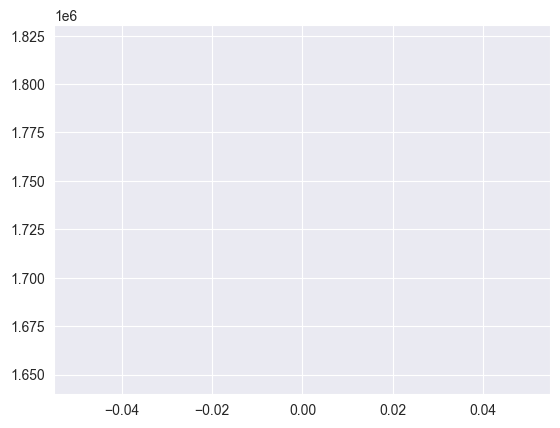

In [74]:
plt.plot(range(len(history)), history, color="skyblue")
plt.show()

# Evalutation

An extensive overview of the different possibilities to evaluate the quality of word-embeddings is given in this paper:

***[A Survey of Word Embeddings Evaluation Methods](https://arxiv.org/abs/1801.09536)***

It is common to distinguish between intrinsic and extrinsic methods of evaluation.

## Intrinsic evaluation

### Cosine Similarity

* ***cosine similarity = 1***
  The 2 vectors are in the same direction, i.e., they are identical or pointing in exactly the same direction.
* ***cosine similarity = -1***
  The 2 vectors are in opposite directions, i.e., they are exactly opposite to each other.
* ***cosine similarity = 0***
  The 2 vectors are orthogonal or perpendicular to each other, i.e., they have no similarity in their orientation.

In [7]:
def calc_cosine_similarity(word_a, word_b):
    dot_product = np.dot(word_a, word_b)
    norm_a = np.linalg.norm(word_a)
    norm_b = np.linalg.norm(word_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

In [8]:
def calc_score(word, model_pre, model_post):
    try:
        cos_similarity = calc_cosine_similarity(model_pre[word], model_post[word])
    except KeyError:
        # if the word is not found this means it disappeared, and we assign it a similarity score of 0
        return 0
    return cos_similarity

In [9]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

tokens_intersection = intersection(tokens_stream_1, tokens_stream_2)

NameError: name 'tokens_stream_1' is not defined

In [10]:
scored_words_list = {}

for word in tqdm(tokens_intersection):
    scored_words_list[word] = calc_score(word, model_stream_1.wv, model_stream_2.wv)

scored_words_list = sorted(scored_words_list.items(), key=lambda x: x[1])

NameError: name 'tokens_intersection' is not defined

The list "scored_words_list" contains the whole vocabulary of both corpora along with the cosine simililarity scores of the words evaluated for two different time points. It is sorted in ascending order, which puts the words that have changed their meaning (= the context people where using them in) the most.

In [11]:
scored_words_list

{}

In [12]:
model_stream_1.wv.most_similar("fairer")

NameError: name 'model_stream_1' is not defined

In [13]:
model_stream_2.wv.most_similar("fairer")

NameError: name 'model_stream_2' is not defined

As we can see for the word ***fairer***, which had a score of -0.58 and was at the top of our list, has totally different neighboring words in the embedding dimensions of the different time slices

As we got 2 top-10 NN-Lists one can think of evaluating them with metrics from information retrieval like MRR or MAP

## Sentiment Analysis (Extrinsic evaluation)

### Model

In [408]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

Test

In [409]:
sia.polarity_scores('I am happy')

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [410]:
sampled_data = stream_data_filtered.sample(n=500, random_state=1040)

In [411]:
res = {}
for i, row in tqdm(sampled_data.iterrows(), total = len(sampled_data)):
    text = row["text"]
    id = row["id"]
    res[id] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [416]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index":"id"})
vaders = vaders.merge(sampled_data, how="left")

In [417]:
vaders.head()

id    neg    neu    pos  \
0  https://www.mercurynews.com/2022/11/08/milpita...  0.012  0.857  0.131   
1       60449667441_577271361098462_2160037890847473  0.000  1.000  0.000   
2  https://newsbk.com/news/health/release-the-man...  0.078  0.922  0.000   
3  1115616568456201_9440848315932943_139979481412...  0.184  0.565  0.251   
4  https://sports.yahoo.com/tom-brady-charity-goo...  0.000  0.836  0.164   

   compound                                               text  \
0    0.8910  candid race mayor seat citi 80000 promis cultu...   
1    0.0000                                               amen   
2   -0.5267  releas manifesto 27 minut ago fox newsufoxnew ...   
3    0.0201  also pleas dont go work sick dont tri hero nob...   
4    0.9607  part commit empow anyon live painfre perform b...   

                 date sentiment  
0 2022-11-09 02:22:00  Neutrals  
1 2023-02-19 01:35:53  Neutrals  
2 2023-03-30 20:51:00  Neutrals  
3 2023-03-24 00:09:10  Neutrals  
4 2022-11-17 15:22:00  Neutrals

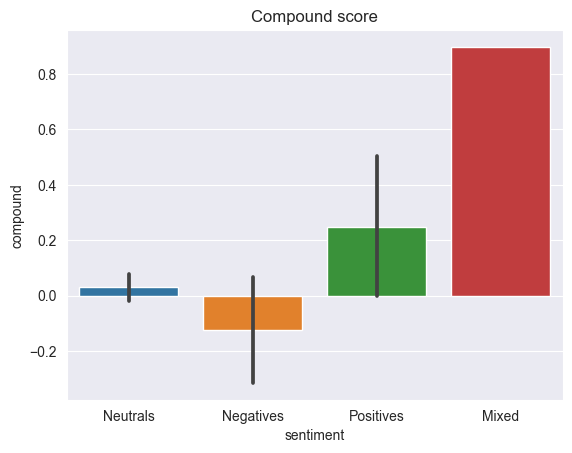

In [418]:
ax = sns.barplot(data=vaders, x="sentiment", y="compound")
ax.set_title("Compound score")
plt.show()

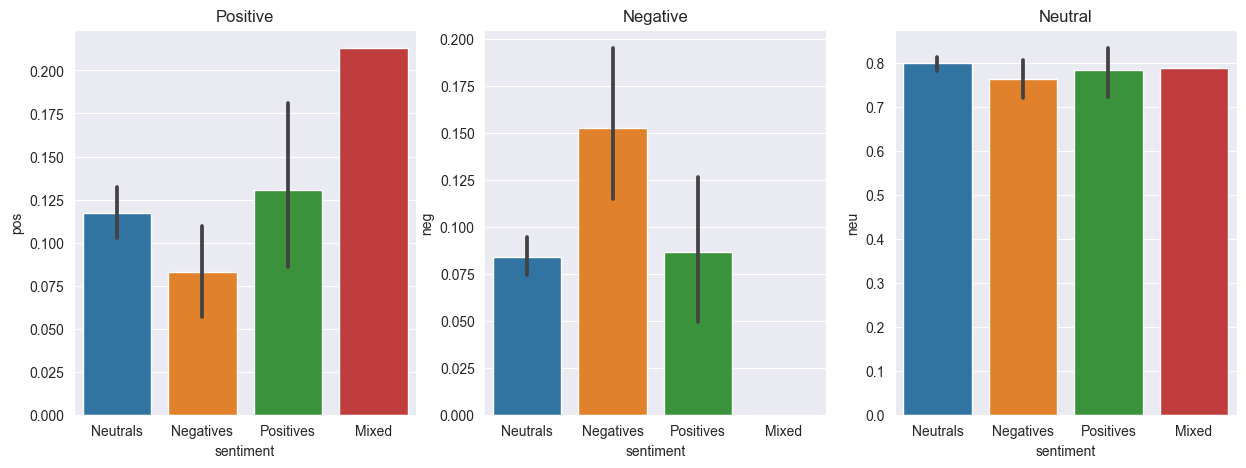

In [419]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=vaders, x="sentiment", y="pos", ax = axs[0])
sns.barplot(data=vaders, x="sentiment", y="neg", ax = axs[1])
sns.barplot(data=vaders, x="sentiment", y="neu", ax = axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Negative")
axs[2].set_title("Neutral")
#plt.tight_layout()
plt.show()

### Roberta Pretrained Model (Work in Progress)

There is currently an issue with Pytorch and its dependencies, so the following Code-Chunks might not work

In [426]:
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [427]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [428]:
null_counts = vaders.isnull().sum()

null_counts

id           24
neg           0
neu           0
pos           0
compound      0
text          0
date          0
sentiment    24
dtype: int64

First Test / Comparison

In [429]:
def calc_scores_roberta(example):
    encoded_example = tokenizer(example["text"], return_tensors="pt")

    output = model(**encoded_example)
    scores = output[0][0].detach().numpy()
    print("scores")
    print(scores)
    scores = softmax(scores)
    print("softmax")
    print(scores)

    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
    }
    return scores_dict

In [430]:
example = sampled_data.sample(n=1).iloc[0][["text", "sentiment"]]
example["text"]

'john mcgrath actual didnt group claim tri sell part video sinc proven edit guy kind troubl fraud unless actual evid case come sourc fulli debunk reason think occur ac hot bed'

In [431]:
example["sentiment"]

'Neutrals'

In [432]:
# create tokenized word-embeddings
print(example["sentiment"])
print("Vader:")
print(sia.polarity_scores(example["text"]))

scores_dict = calc_scores_roberta(example)
print("Roberta:")
print(scores_dict)

Neutrals
Vader:
{'neg': 0.105, 'neu': 0.801, 'pos': 0.094, 'compound': -0.1027}


ImportError: Unable to convert output to PyTorch tensors format, PyTorch is not installed.

In [433]:
res = {}
for i, row in tqdm(sdf.iterrows(), total=len(sdf)):
    text = row["text"]
    myid = row["id"]
    print(myid)
    '''
    vader_result = sia.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    roberta_result = calc_scores_roberta(text)
    combined = {**vader_result, **roberta_result}
    res[myid] = combined
    break'''

  0%|          | 0/500 [00:00<?, ?it/s]

101043269988443_685479222937141_641761047285352
102479025168087_499693558822805_1195202924611670
10643211755_10161745802786756_627308188838071
10643211755_10161748775911756_1235289853921186
101043269988443_687503842734679_3330045383891840
3340583057595617661
85452072376_10159390884612377_492124479175547
102479025168087_505950188197142_1003159900465043
17045042172747689582
5550296508_10162942404151509_3174345489492387
85452072376_10159392209917377_1173019323628854
1535911377080094720
1574411970182512640
1115616568456201_8130862066931581_3732614016862776
1534650398568599553
1561461489059258370
1534653775432011777
1550663069281521665
https://linustechtips.com/topic/1446460-dont-buy-everything-i-recommend/#comment-15502350.2
8f6ymwe/post/2022-06-08T17:39:10
6149699161_10161011833389162_792804665062941
BRDRDT2-t1_ibg3kgi
95926963131_10161751522313132_811991919981815
nan
nan
nan
1534651955091492867
BRDRDT2-t1_ipz8q8j
nan
BRDRDT2-t1_ipz1z40
1545932536097824768
82295304916_10160477911909917_65